# Exploratory Data Analysis

In [1]:
from glob import glob
import pandas as pd
import sqlite3
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import display, HTML

## Data Wrangling

In [2]:
conn = sqlite3.connect("images.db")
c = conn.cursor()

all_record_ids = {}
all_labels = {}
i = 0
for line in open("./iNaturalist/images/Poison Ivy/classes.txt"):
    all_labels[str(i)] = line.strip()
    i += 1

object_counts = {}
image_counts = {}
image_counts_by_primary_label = {}
objects_per_image = {}
for k, the_label in all_labels.items():
    record_ids = set()
    pattern = "./iNaturalist/images/" + the_label + "/*.txt"
    labels = glob(pattern)
    labels.remove("./iNaturalist/images/" + the_label + "\\classes.txt")
    image_counts_by_primary_label[the_label] = len(labels)
    for f in labels:
        record_id = int(f.split("\\")[-1].split(".txt")[0])
        record_ids.add(record_id)
        for line in open(f):
            label_id = line.split(" ")[0]
            this_label = all_labels[label_id]
            object_counts[this_label] = object_counts.get(this_label, 0) + 1
            ic = image_counts.get(this_label, set())
            ic.add(f)
            image_counts[this_label] = ic
            objects_per_image[this_label] = objects_per_image.get(this_label, dict())
            objects_per_image[this_label][record_id] = objects_per_image[this_label].get(record_id, 0) + 1
    all_record_ids[the_label] = record_ids

image_dict = {}
for k, v in image_counts.items():
    image_dict[k] = len(v)
    
# How many "plants" are found in each image?
objects_per_image_counts = {}
for k, v in objects_per_image.items():
    objects_per_image_counts[k] = {}
    for x, k2 in v.items():
        objects_per_image_counts[k][k2] = objects_per_image_counts[k].get(k2, 0) + 1

max_object_count = 0
for k, v in objects_per_image_counts.items():
    for k2, v2 in v.items():
        if k2 > max_object_count:
            max_object_count = k2
            
# Add in the zeros into the object per image counts

for k in all_labels.values():
    for i in range(1, max_object_count + 1):
        objects_per_image_counts[k][i] = objects_per_image_counts[k].get(i, 0)

objects_per_image_counts_df = []
for k, v in objects_per_image_counts.items():
    for k2, v2 in v.items():
        objects_per_image_counts_df.append({"Plant Type": k, "Objects": k2, "Images": v2})
objects_per_image_counts_df = pd.DataFrame(objects_per_image_counts_df)


# Get the counts by month and the coords
all_month_counts = {}
coords = []
for k, v in all_labels.items():
    plant_month_counts = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}
    c.execute("SELECT * FROM images WHERE label LIKE '" + v + "'")
    record_ids = all_record_ids[v]
    for row in c.fetchall():
        date = row[6]
        try:
            month = int(date.split("-")[1])
        except:
            month = None
        if row[0] in record_ids:
            coords.append({"Plant Type":all_labels[k], "lat":row[4], "lon":row[5]})        
            plant_month_counts[month] = plant_month_counts.get(month, 0) + 1
    all_month_counts[v] = plant_month_counts
    
all_month_counts_df = []
for k,v in all_month_counts.items():
    for k2,v2 in v.items():
        all_month_counts_df.append({"Plant Type":k, "Month":k2, "Images":v2})
all_month_counts_df = pd.DataFrame(all_month_counts_df)

coords_df = pd.DataFrame(coords)

## Image Counts

### By Primary Label

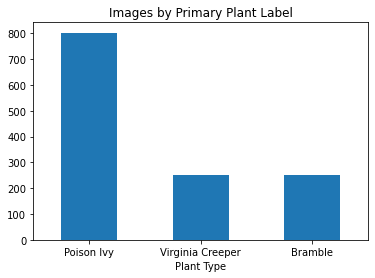

In [3]:
image_counts_by_primary_label_df = pd.DataFrame.from_dict(image_counts_by_primary_label, orient="index", columns=["Images"]).reset_index().rename(columns={"index":"Plant Type"}).reset_index(drop=True)
image_counts_by_primary_label_df.plot.bar(x="Plant Type", y="Images", rot=0, legend=False, title="Images by Primary Plant Label");

In [4]:
for k, v in image_counts_by_primary_label.items():
    print(k, v)

Poison Ivy 803
Virginia Creeper 250
Bramble 250


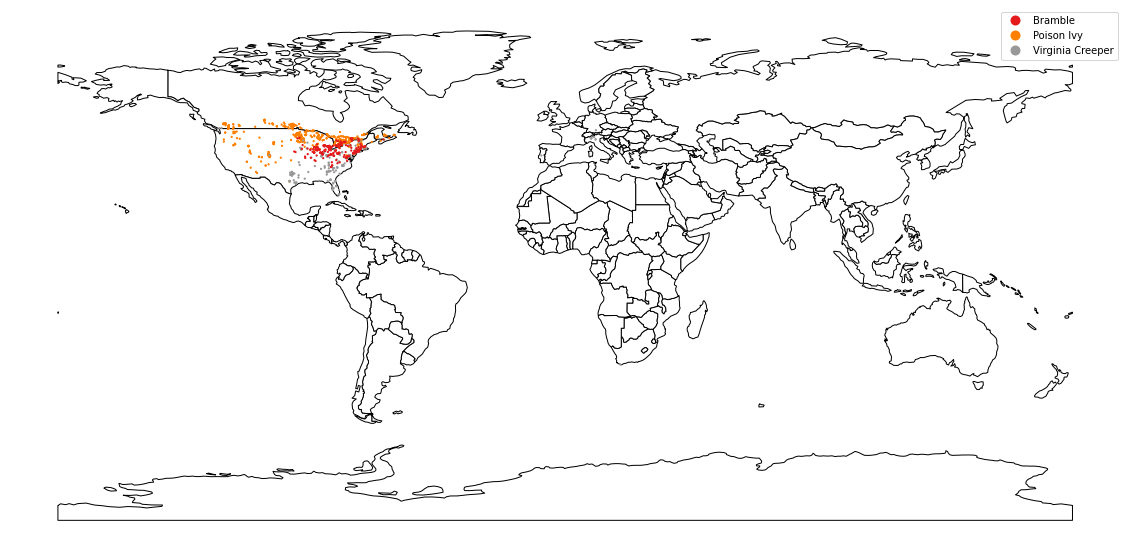

In [5]:
brewer_cmap = cm.get_cmap("Set1")
gdf = gpd.GeoDataFrame(coords_df, geometry=gpd.points_from_xy(coords_df.lon, coords_df.lat))
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
fig, ax = plt.subplots(figsize=(20, 20))
world.plot(color="white", edgecolor="black", ax=ax)
gdf.plot(column='Plant Type', categorical=True, legend=True, ax=ax, markersize=1.5, cmap=brewer_cmap)
ax.set_axis_off()
plt.show()

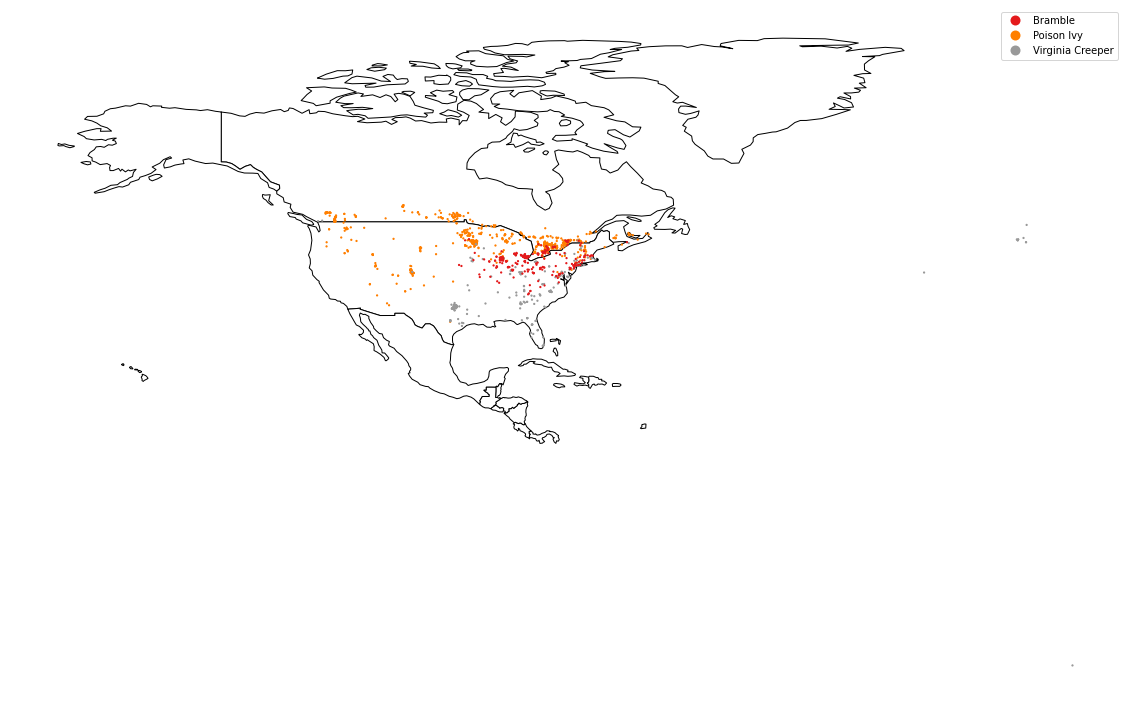

In [6]:
fig, ax = plt.subplots(figsize=(20,20))
north_america = world[world.continent == "North America"].plot(color="white", edgecolor="black", ax=ax)
gdf.plot(column="Plant Type", categorical=True, legend=True, ax=ax, cmap=brewer_cmap, markersize=1.5)
ax.set_axis_off()
plt.show()

### In Total (Across Primary Label Types)

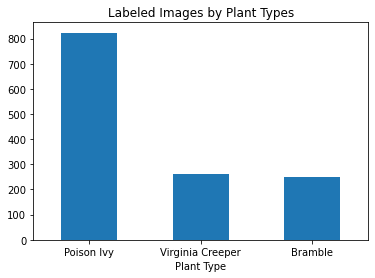

In [7]:
image_dict_df = pd.DataFrame.from_dict(image_dict, orient="index", columns=["Images"]).reset_index().rename(columns={"index":"Plant Type"}).reset_index(drop=True)
image_dict_df.plot.bar(x="Plant Type", y="Images", rot=0, legend=False, title="Labeled Images by Plant Types");

In [8]:
for k, v in image_dict.items():
    print(k, v)

Poison Ivy 823
Virginia Creeper 262
Bramble 250


### By Month

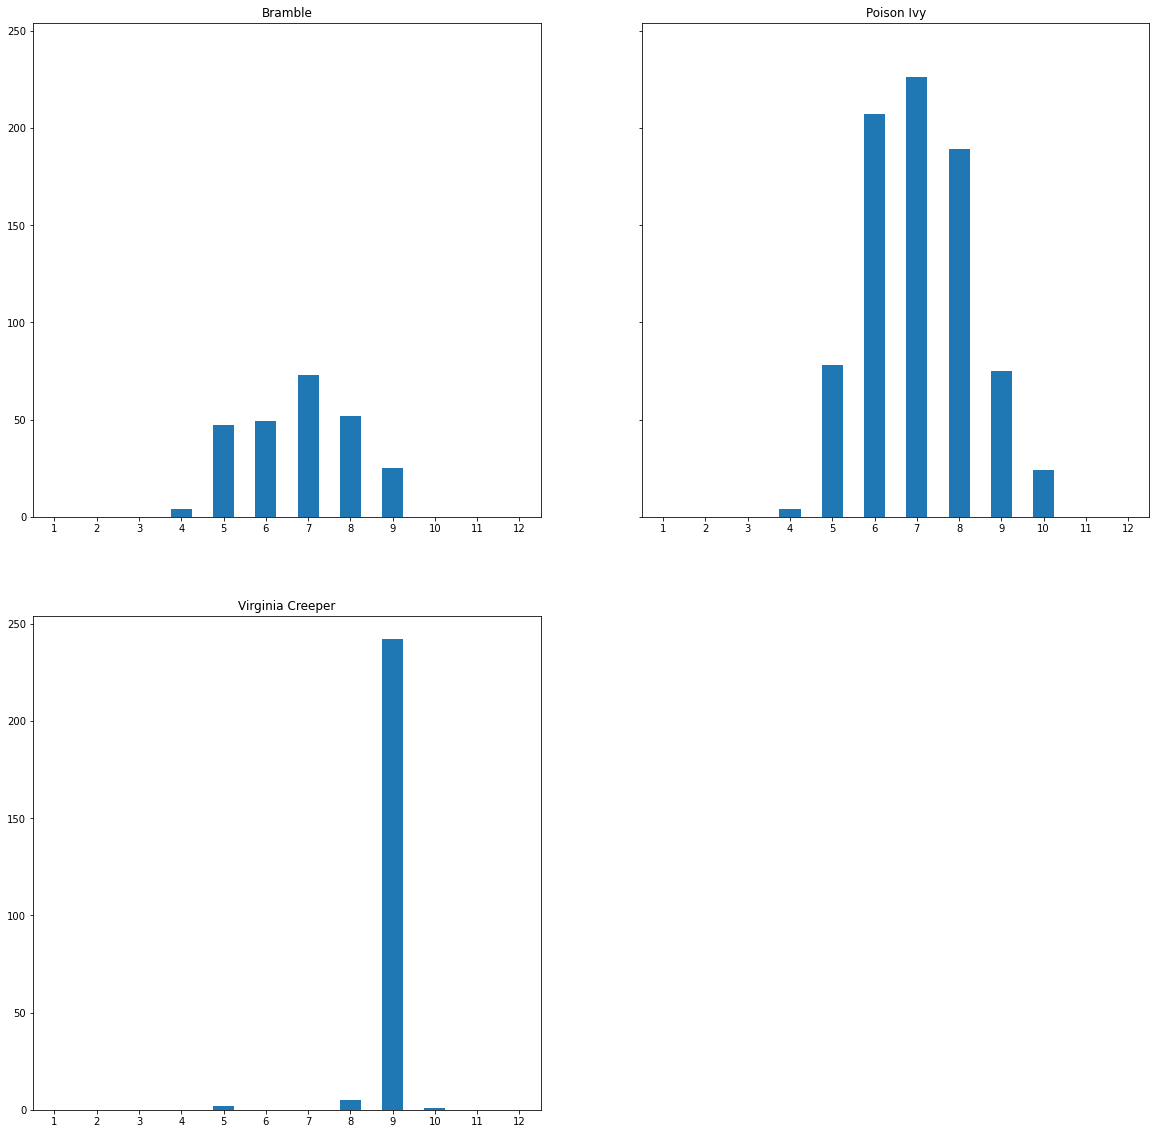

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(20,20))
axes_list = [item for sublist in axes for item in sublist] 

for plant_type, selection in all_month_counts_df.groupby("Plant Type"):
    ax = axes_list.pop(0)
    selection = selection.sort_values(by=["Month"])
    selection.plot.bar(x="Month", y="Images", ax=ax, rot=0, legend=False, label=plant_type);
    ax.set_title(plant_type)
    ax.set_xlabel("")
for ax in axes_list:
    ax.remove()

## Object Counts

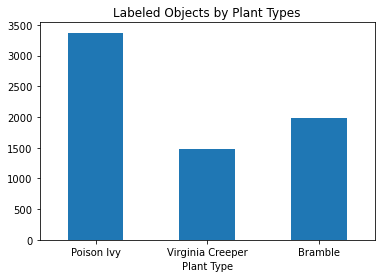

In [10]:
object_counts_df = pd.DataFrame.from_dict(object_counts, orient="index", columns=["Objects"]).reset_index().rename(columns={"index":"Plant Type"}).reset_index(drop=True)
object_counts_df.plot.bar(x="Plant Type", y="Objects", rot=0, legend=False, title="Labeled Objects by Plant Types");

In [11]:
for k, v in object_counts.items():
    print(k, v)

Poison Ivy 3372
Virginia Creeper 1473
Bramble 1980


### Objects Per Image

In [12]:
max_object_count

35

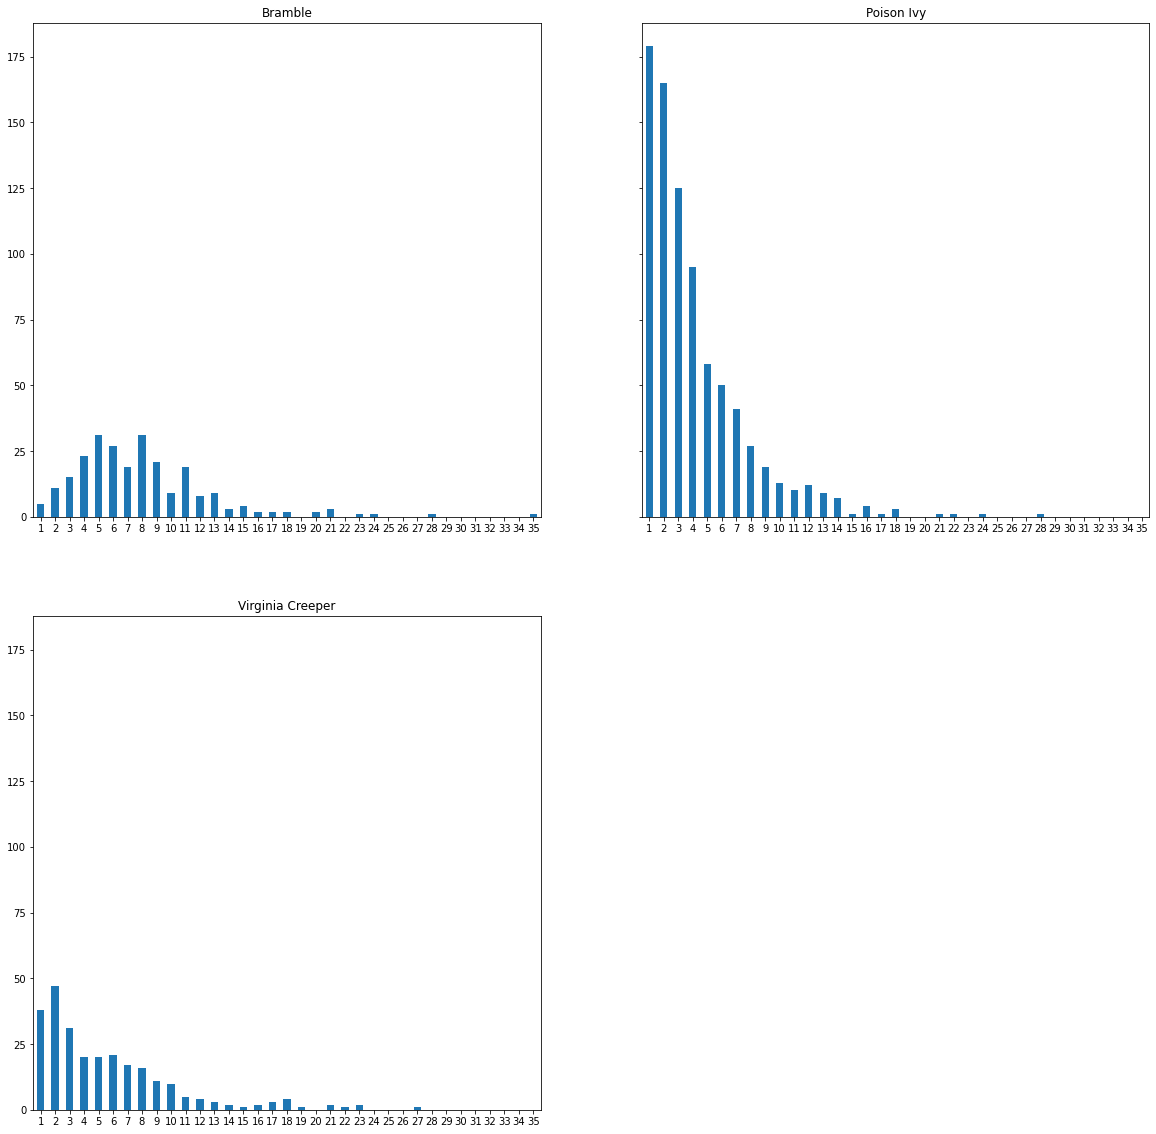

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(20,20))
axes_list = [item for sublist in axes for item in sublist] 

for plant_type, selection in objects_per_image_counts_df.groupby("Plant Type"):
    ax = axes_list.pop(0)
    selection = selection.sort_values(by=["Objects"])
    selection.plot.bar(x="Objects", y="Images", ax=ax, rot=0, legend=False, label=plant_type);
    ax.set_title(plant_type)
    ax.set_xlabel("")
for ax in axes_list:
    ax.remove()